In [1]:
from utility import *
from supportkit import *
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sym_eva_S_moment(1, 1)

In [3]:
moments = sym_eva_qubit_moments()
moments['a11']

In [4]:
moments['a12']

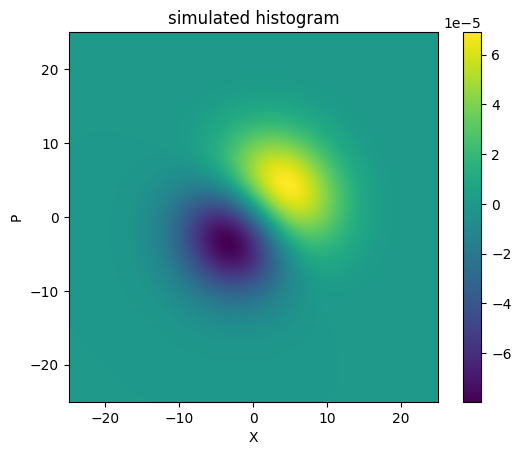

In [5]:
# use gaussian as simulated measurement result, might be physicall impossible
D_S, S = generate_2d_gaussian(
    means=[0.1, 0.1],
    sigmas=[5.71, 5.71],
    ranges=(25, 25)
)
D_h, S = generate_2d_gaussian(
    means=[0, 0],
    sigmas=[5.7, 5.7],
    ranges=(25, 25)
)
plot_complex_2dfunc(D_S - D_h, S, title='simulated histogram')

In [6]:
for n in range(4):
    for m in range(4):
        print(f'<S†{n} S{m}> = {eva_S_moment(S, n, m, D_S): .4e}', end=', \t')
        print(f'<h{n} h†{m}> = {eva_h_moment_anti(S, n, m, D_h): .4e}')

<S†0 S0> =  9.9998e-01+0.0000e+00j, 	<h0 h†0> =  9.9998e-01+0.0000e+00j
<S†0 S1> =  9.9974e-02+9.9974e-02j, 	<h0 h†1> =  1.1628e-17+5.7930e-16j
<S†0 S2> =  2.5636e-15+1.9990e-02j, 	<h0 h†2> =  3.8950e-15+2.0844e-16j
<S†0 S3> = -1.4478e-02+1.4478e-02j, 	<h0 h†3> = -2.8142e-15+3.5102e-14j
<S†1 S0> =  9.9974e-02-9.9974e-02j, 	<h1 h†0> =  1.1628e-17-5.7930e-16j
<S†1 S1> =  6.5211e+01+8.9491e-19j, 	<h1 h†1> =  6.4964e+01+9.7588e-19j
<S†1 S2> =  1.3025e+01+1.3025e+01j, 	<h1 h†2> =  1.3160e-15-1.9040e-14j
<S†1 S3> = -5.0202e-13+3.9050e+00j, 	<h1 h†3> =  5.7847e-14+9.1170e-15j
<S†2 S0> =  2.5636e-15-1.9990e-02j, 	<h2 h†0> =  3.8950e-15-2.0844e-16j
<S†2 S1> =  1.3025e+01-1.3025e+01j, 	<h2 h†1> =  1.3160e-15+1.9032e-14j
<S†2 S2> =  8.4971e+03-1.1005e-16j, 	<h2 h†2> =  8.4329e+03-1.0522e-16j
<S†2 S3> =  2.5380e+03+2.5380e+03j, 	<h2 h†3> = -1.7897e-13-9.9942e-13j
<S†3 S0> = -1.4478e-02-1.4478e-02j, 	<h3 h†0> = -2.8142e-15-3.5102e-14j
<S†3 S1> = -5.0202e-13-3.9050e+00j, 	<h3 h†1> =  5.7847e-14+2.04

In [7]:
moments = eva_qubit_moments(S, D_S, D_h)
moments

{'a00': 1,
 'a10': np.complex128(0.09997402687310694-0.09997402687310646j),
 'a01': np.complex128(0.09997402687310694+0.09997402687310646j),
 'a20': np.complex128(-1.2178776704284442e-15-0.019990082445562152j),
 'a11': np.complex128(0.2475524043228461-8.096934378251652e-20j),
 'a02': np.complex128(-1.2178776704284442e-15+0.019990082445562152j),
 'a30': np.complex128(-0.014477629514892308-0.014477629514839982j),
 'a21': np.complex128(0.0353267907431043-0.03532679074315226j),
 'a12': np.complex128(0.0353267907431043+0.03532679074314693j),
 'a03': np.complex128(-0.014477629514892308+0.014477629514839982j),
 'a40': np.complex128(-0.30354647774097643+1.6694057559605813e-14j),
 'a31': np.complex128(-3.3468164331344426e-13-0.009148112905327022j),
 'a22': np.complex128(-0.17198097593791317+1.694313310036295e-17j),
 'a13': np.complex128(-3.346840716733978e-13+0.009148112905335015j),
 'a04': np.complex128(-0.30354647774097643-1.6694057559605813e-14j)}

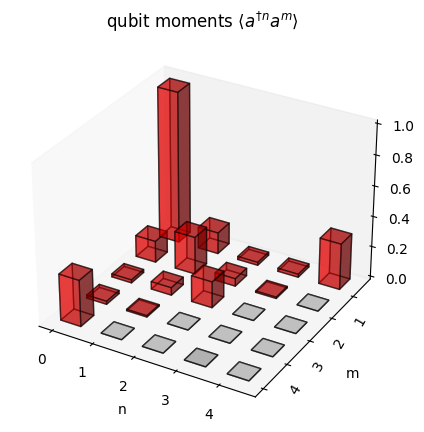

In [8]:
plot_moments_bar_diagram(moments, title='qubit moments $\\langle a^{\\dagger n} a^m \\rangle$')

In [9]:
# Construct winger function from given moments
lambd = generate_complex_2dcoord(5, 51)
W = get_winger_function_func(3, 3, lambd, moments)
alpha = generate_complex_2dcoord(1.2, 151)
W_values = W(alpha)

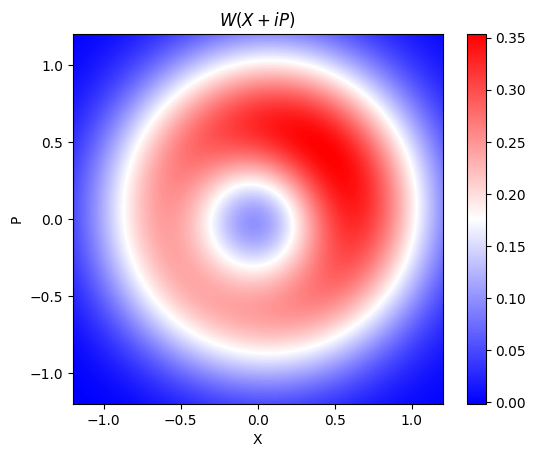

In [10]:
plot_complex_2dfunc(np.real(W_values), alpha, title='$W(X+iP)$', cmap='bwr')

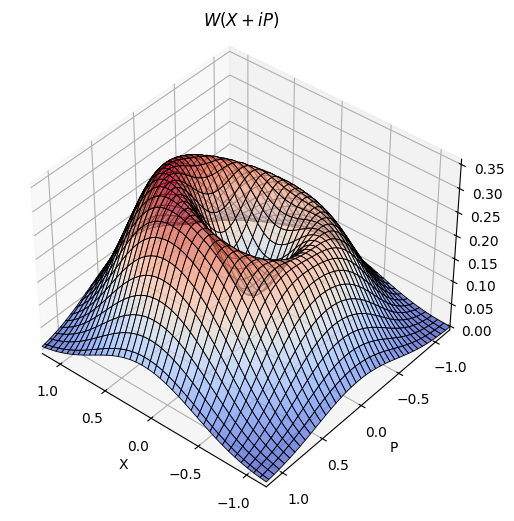

In [11]:
plot_complex_2dfunc_in3d(np.real(W_values), alpha, title='$W(X+iP)$',
                         elev=40, azim=130)

In [12]:
# single photon state |1>. <1|a†a|1> = 1, others are zero, trivially
# moments = {'a00': 1, 'a11': 1} 
moments = {'a00': 1, 'a11': 1} 
mle_density_matrix(2, 3, 3, moments)

array([[ 3.08148793e-17, -5.55111514e-09],
       [-5.55111514e-09,  1.00000000e+00]])

In [13]:
# supposed try to construct |0> + |1> state with devi in measurment
moments_exp = {'a00': 1, 'a11': 0.57, 'a01': 0.1, 'a10': 0.15}
rho_ideal = np.array([
    [0.5,   0],
    [  0, 0.5]
])

rho_fit = mle_density_matrix(2, 3, 3, moments_exp, stddevi={})
print(rho_fit)
compute_similarities(rho_fit, rho_ideal)

[[0.42999892 0.1250009 ]
 [0.1250009  0.57000108]]


{'Fidelity': np.float64(0.9790350982653181),
 'Trace Distance': np.float64(0.14326679528047118),
 'Hilbert-Schmidt Distance': np.float64(0.0410507492598729)}